<h1 style="color:rgb(0,120,170)">Hands-on AI II</h1>
<h2 style="color:rgb(0,120,170)">Unit 4 &mdash; Recurrent Neural Networks (Assignment)</h2>

<b>Authors:</b> B. Schäfl, S. Lehner, J. Brandstetter<br>
<b>Date:</b> 30-04-2021

This file is part of the "Hands-on AI II" lecture material. The following copyright statement applies to all code within this file.

<b>Copyright statement:</b><br>
This  material,  no  matter  whether  in  printed  or  electronic  form,  may  be  used  for personal  and non-commercial educational use only.  Any reproduction of this manuscript, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

<h2>Table of contents</h2>
<ol>
    <a href="#exercise-latch-sequence-set"><li style="font-size:large;font-weight:bold">The Latch Sequence Data Set</li></a>
    <ol style="margin-bottom:15px">
        <a href="#exercise-latch-sequence-set-one"><li style="font-size:medium">Visualizing data set statistics</li></a>
        <a href="#exercise-latch-sequence-set-two"><li style="font-size:medium">Splitting and preparing</li></a>
    </ol>
    <a href="#exercise-latch-cnn"><li style="font-size:large;font-weight:bold">Tackling Sequence Data with CNNs</li></a>
    <ol style="margin-bottom:15px">
        <a href="#exercise-latch-cnn-one"><li style="font-size:medium">Approximating performances of random models</li></a>
        <a href="#exercise-latch-cnn-two"><li style="font-size:medium">Applying 1D convolutions to sequences</li></a>
        <a href="#exercise-latch-cnn-three"><li style="font-size:medium">Analyzing gradients of a CNN model</li></a>
    </ol>
    <a href="#exercise-latch-lstm"><li style="font-size:large;font-weight:bold">Tackling Sequence Data with LSTMs</li></a>
    <ol style="margin-bottom:15px">
        <a href="#exercise-latch-lstm-one"><li style="font-size:medium">Applying LSTMs to sequences</li></a>
        <a href="#exercise-latch-lstm-two"><li style="font-size:medium">Analyzing gradients of an initialized LSTM model</li></a>
        <a href="#exercise-latch-lstm-three"><li style="font-size:medium">Analyzing gradients of a trained LSTM model</li></a>
        <a href="#exercise-latch-lstm-four"><li style="font-size:medium">The effect of the forget gate in an LSTM</li></a>
    </ol>
</ol>

<h3 style="color:rgb(0,120,170)">How to use this notebook</h3>
This notebook is designed to run from start to finish. There are different tasks (displayed in <span style="color:rgb(248,138,36)">orange boxes</span>) which require your contribution (in form of code, plain text, ...). Most/All of the supplied functions are imported from the file <code>u4_utils.py</code> which can be seen and treated as a black box. However, for further understanding, you can look at the implementations of the helper functions. In order to run this notebook, the packages which are imported at the beginning of <code>u4_utils.py</code> need to be installed.

In [1]:
# Import pre-defined utilities specific to this notebook.
import u4_utils as u4

# Import additional utilities needed in this notebook.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

# Setup Jupyter notebook (warning: this may affect all Jupyter notebooks running on the same Jupyter server).
u4.setup_jupyter()

<h3 style="color:rgb(0,120,170)">Module versions</h3>
As mentioned in the introductiory slides, specific minimum versions of Python itself as well as of used modules is recommended.

In [2]:
u4.check_module_versions()

Installed Python version: 3.9 (✓)
Installed numpy version: 1.20.2 (✓)
Installed pandas version: 1.2.4 (✓)
Installed PyTorch version: 1.8.1 (✓)
Installed scikit-learn version: 0.24.2 (✓)
Installed scipy version: 1.6.3 (✓)
Installed matplotlib version: 3.4.2 (✓)
Installed seaborn version: 0.11.1 (✓)
Installed PIL version: 8.1.2 (✓)
Installed rdkit version: 2021.03.1 (✓)


<a name="exercise-latch-sequence-set"></a><h2>The Latch Sequence Data Set</h2>
<p>In the accompanying excercise class, the <i>latch task</i> was presented. You'll be working with the same data set in this assignment. The original latch task was introduced by Hochreiter and Mozer:
<center>
    <cite>Sepp Hochreiter, Michael Mozer, 2001. A discrete probabilistic memory model for discovering dependencies in time. Artificial Neural Networks -- ICANN 2001, 13, pp.661-668.</cite>
</center></p>

<p>The essence of this task is that a sequence of inputs is presented, beginning with one of two symbols, <b>A</b> or <b>B</b>, and after a variable number of time steps, the model has to output a corresponding symbol. Thus, the task requires memorizing the original input over time. It has to be noted, that in the <i>original</i> task desription, both class-defining symbols must only appear at the first position of an instance.</p>

<p>The modified version of this task used in this assignment is identical to the one discussed during the accompanying exercise, with the difference of a higher amount of possible targets. Defining arguments are:

<table>
    <tr>
        <th>Argument</th>
        <th>Value (used in this assignment)</th>
        <th>Description</th>
    </tr>
    <tr>
        <th><code>num_samples</code></th>
        <th>4096</th>
        <th>Amount of samples of the full dataset.</th>
    </tr>
    <tr>
        <th><code>num_instances</code></th>
        <th>48</th>
        <th>Amount of instances per sample (sample length).</th>
    </tr>
    <tr>
        <th><code>num_characters</code></th>
        <th>26</th>
        <th>Amount of different characters (size of the one-hot encoded vector).</th>
    </tr>
    <tr>
        <th><code>num_targets</code></th>
        <th>25</th>
        <th>Amount of different characters used as possible targets.</th>
    </tr>
    <tr>
        <th><code>seed</code></th>
        <th>42</th>
        <th>Random seed used to generate the samples of the data set.</th>
    </tr>
</table></p>

<a name="exercise-latch-sequence-set-one"></a><div class="alert alert-warning">
    Execute the notebook until here and try to solve the following tasks:
    <ul>
        <li>Generate a <i>latch sequence</i> data set with the properties as described in the table <i>above</i>.</li>
        <li>Visualize the last sequence of the data set in <i>tabular</i> form, with all $1$ 
            in <b style="color:magenta">bold magenta</b> and all $0$ in <span style="font-weight: lighter">lighter</span>.</li>
        <li>Visualize the <i>first</i> $32$ samples in a heatmap, once <i>without</i> and once <i>with</i> a corresponding prefix-mask.</li>
        <li>Interpreting the previous visualizations, which <i>character</i> of the chosen alphabet determines the <i>prefix</i>?</li>
    </ul>
</div>

In [3]:
data_latch = u4.LatchSequenceSet(
    num_samples=4096,
    num_instances=48,
    num_characters=26,
    num_targets=25,
    seed=42)

# Visualize the last generated sequence of the latch data set.
data_sample = pd.DataFrame(data_latch[-1][0].transpose(0, 1).numpy()).astype(int)
data_sample.style.applymap(lambda _: f'color: {r"magenta;font-weight: bold" if _ == 1.0 else r"pink;font-weight: lighter"}')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


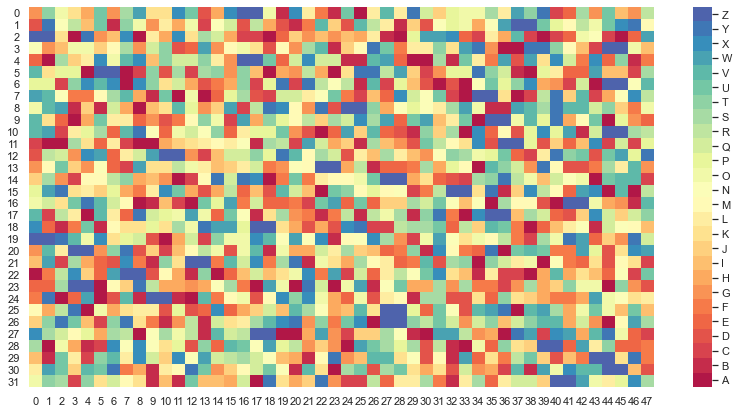

In [4]:
# Set default plotting style as well as random seed for reproducibility.
sns.set()
np.random.seed(seed=42)
torch.manual_seed(seed=42)

# Prepare mini-batch of latch sequence data set for plotting.
data_heatmap = iter(data_latch[:32][0])
data_heatmap = pd.DataFrame(map(lambda _: torch.argmax(_, dim=1).numpy(), data_heatmap))

# Plot heatmap of a mini-batch of the latch sequence data set w.r.t. the comprised characters.
u4.plot_heatmap(data=data_heatmap, prefix_mask=False, prefix_index=data_latch.num_targets, figsize=(14, 7))

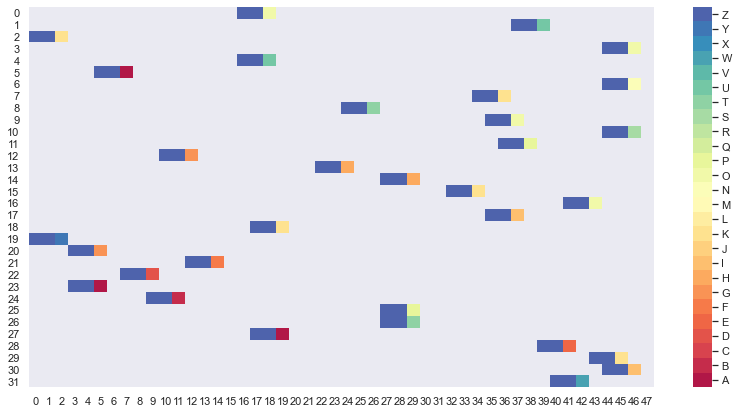

In [5]:
# Set default plotting style as well as random seed for reproducibility.
sns.set()
np.random.seed(seed=42)
torch.manual_seed(seed=42)

# Prepare mini-batch of latch sequence data set for plotting.
data_heatmap = iter(data_latch[:32][0])
data_heatmap = pd.DataFrame(map(lambda _: torch.argmax(_, dim=1).numpy(), data_heatmap))

# Plot heatmap of a mini-batch of the latch sequence data set w.r.t. the comprised characters.
u4.plot_heatmap(data=data_heatmap, prefix_mask=True, prefix_index=data_latch.num_targets, figsize=(14, 7))

The character Z determines the prefix, more specifically double Z.

<a name="exercise-latch-sequence-set-two"></a><div class="alert alert-warning">
    Execute the notebook until here and try to solve the following tasks:
    <ul>
        <li>Linearly split the data set into a <i>training</i> and a <i>test</i> set in a ratio of $3:1$ (use a <tt>SubsetRandomSampler</tt> and a batch size of $48$).</li>
        <li>Compute and print the <i>amount of samples</i> of each of the respective sets and verify the $3 : 1$ split.</li>
        <li>Visualize the <i>character counts</i> of the <i>first</i> training mini-batch appropriately. What is the count of the <i>prefix</i> character?</li>
    </ul>
</div>

In [6]:
# Set random seed for reproducibility.
np.random.seed(seed=42)
torch.manual_seed(seed=42)

# Specify batch as well as test size.
batch_size = 48
test_size = min(max(1, data_latch.num_samples // 4), len(data_latch) - 1)

# Create data loader of training set.
sampler_train = torch.utils.data.SubsetRandomSampler(list(range(
    test_size, data_latch.num_samples)))
data_loader_train = torch.utils.data.DataLoader(
    dataset=data_latch, batch_size=batch_size, sampler=sampler_train)

# Create data loader of test set.
sampler_test = torch.utils.data.SubsetRandomSampler(list(range(test_size)))
data_loader_test = torch.utils.data.DataLoader(
    dataset=data_latch, batch_size=batch_size, sampler=sampler_test)

In [7]:
print(f'The training set consists of "{len(sampler_train)}" samples, '
      f'whereas the test set comprises "{len(sampler_test)}" samples.')

The training set consists of "3072" samples, whereas the test set comprises "1024" samples.


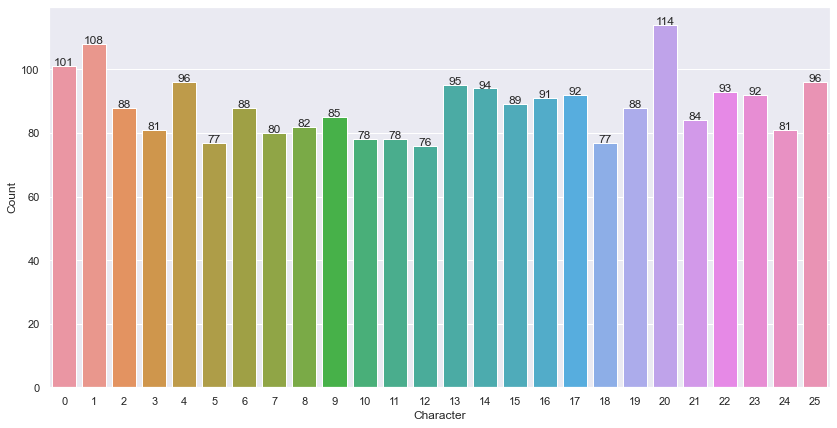

In [8]:
# Set default plotting style as well as random seed for reproducibility.
sns.set()
np.random.seed(seed=42)
torch.manual_seed(seed=42)

# Prepare mini-batch of latch sequence data set for plotting.
data_histogram = iter(data_loader_train).next()[0]
data_histogram = pd.DataFrame(map(lambda _: torch.argmax(_, dim=1).numpy(), data_histogram))
data_histogram = data_histogram.to_numpy().flatten()

# Plot heatmap of a mini-batch of the latch sequence data set w.r.t. the comprised characters.
fig, ax = plt.subplots(figsize=(14, 7))
count_plot = sns.countplot(x=data_histogram, ax=ax)
_ = count_plot.set(xlabel=r'Character', ylabel=r'Count')

for p in count_plot.patches:
    height = p.get_height()
    count_plot.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

The final count of Z is 96.

<a name="exercise-latch-cnn"></a><h2>Tackling Sequence Data with CNNs</h2>
<p>During the accompanying exercise class, a <i>dense feed-forward</i> network was presented as some kind of baseline. Afterwards, recurrent architectures were applied. In this exercise, you'll be tasked with implementing a <i>convolutional</i> architecture for handling sequence data.</p>

<div class="alert alert-warning">
    The following code snippet is taken from the accompanying exercise notebook. You do not need to modify it for this assignment.
</div>

In [9]:
class TheMightyDice(torch.nn.Module):
    """
    Dice roll "network" tailored to deliver random outcomes.
    """
    
    def __init__(self, output_size: int):
        super(TheMightyDice, self).__init__()
        self.__output_size = output_size
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.rand(size=(x.shape[0], self.__output_size))

<a name="exercise-latch-cnn-one"></a><div class="alert alert-warning">
    Execute the notebook until here and try to solve the following tasks:
    <ul>
        <li>Test a <tt>TheMightyDice</tt> instance on the latch sequence <i>test</i> set. Do you expect this result? Comment on your answer.</li>
        <li>Assume <i>uniformly</i> distributed targets. If a model would <i>always</i> predict the same class, what would the accuracy be?</li>
    </ul>
</div>

In [10]:
# Set random seed for reproducibility.
np.random.seed(seed=42)
torch.manual_seed(seed=42)
target_device='cpu'

# Evaluate dice model on test data set.
performance = u4.test_network(
    model=TheMightyDice(25), data_loader=data_loader_test, device=target_device)
print(f'\nFinal loss: {performance[0]:.4f} / Final accuracy: {performance[1]:.4f}')


Final loss: 0.0701 / Final accuracy: 0.0420


The test set accuracy is very low here. It is the one that I expected, as it is random and we have 25 targets. If only one class would be predicted and we would have only one target than the accuracy would be 100%. However, if we mean that we have more targets - as many of them as number of the variables and only one class would be repeatedly predicted than the accuracy would be 100/(number of targets)

<a name="exercise-latch-cnn-two"></a><div class="alert alert-warning">
    Execute the notebook until here and try to solve the following tasks:
    <ul>
        <li>Implement a function for computing the output size of a convolution operation. Hint: have a look at the <a href="https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html">PyTorch documentation</a>. You may also use <i>your</i> implementation from the <i>first</i> assignment.</li>
        <li>Implement a class <tt>CNN</tt> with the following architecture:</li>
    </ul>
    <table style="text-align:center;vertical-align:middle">
        <th>Position</th>
        <th>Element</th>
        <th>Comment</th>
        <tr>
            <td>0</td>
            <td>input</td>
            <td>-</td>
        </tr>
        <tr>
            <td>1</td>
            <td>1D convolution</td>
            <td>$256$ output channels and a configurable kernel size (specified as an argument to <tt>\_\_init\_\_</tt>)</td>
        </tr>
        <tr>
            <td>2</td>
            <td>ReLU</td>
            <td>-</td>
        </tr>
        <tr>
            <td>3</td>
            <td>1D convolution</td>
            <td>$256$ output channels and the same kernel size as the <i>1D convolution</i> at position $1$</td>
        </tr>
        <tr>
            <td>4</td>
            <td>ReLU</td>
            <td>-</td>
        </tr>
        <tr>
            <td>5</td>
            <td>fully connected</td>
            <td><tt>num_targets</tt> output features (as specified during the data set creation)</td>
        </tr>
        <tr>
            <td>6</td>
            <td>output</td>
            <td>-</td>
        </tr>
    </table>
    <ul>
        <li>Train a <tt>CNN</tt> network for $15$ epochs, print the training accuracy as well as the loss per epoch and report the final test set loss and accuracy. Use a <i>kernel size</i> of $1$.</li>
        <li>Repeat the same procedure with a second <tt>CNN</tt> but a <i>kernel size</i> of $3$. Do you observe any differences? Comment and interpret your results.</li>
    </ul>
</div>

In [11]:
class CNN(torch.nn.Module):

    def __init__(self, input_size, output_size, kernel):
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Conv1d(26, 256, kernel)
        self.conv2 = torch.nn.Conv1d(256, 256, kernel)
        self.fc1 = torch.nn.Linear(256*(48-(kernel-1)*2),output_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.relu(self.conv1(x.transpose(1,2)))
        x = torch.relu(self.conv2(x))
        x = x.view(-1,256*(48-(kernel-1)*2))
        return self.fc1(x)

In [12]:
#kernel=1
# Set random seed for reproducibility.
np.random.seed(seed=42)
torch.manual_seed(seed=42)

# Create CNN instance and the corresponding optimizer to use.
kernel=1
target_device = torch.device(r'cuda' if torch.cuda.is_available() else r'cpu')
cnn_model = CNN(input_size=48,output_size=25,kernel=kernel).to(target_device)
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=1e-3)

# Train and evaluate CNN instance 
num_epochs = 15
for epoch in range(num_epochs):
    
    # Train CNN instance for one epoch.
    u4.train_network(
        model=cnn_model, data_loader=data_loader_train, device=target_device, optimizer=optimizer)
    
    # Evaluate current CNN instance.
    performance = u4.test_network(
        model=cnn_model, data_loader=data_loader_train, device=target_device)
    
    # Print result of current epoch to standard out.
    print(f'Epoch: {str(epoch + 1).zfill(len(str(num_epochs)))} ' +
          f'/ Loss: {performance[0]:.4f} / Accuracy: {performance[1]:.4f}')

# Evaluate final model on test data set.
performance = u4.test_network(
    model=cnn_model, data_loader=data_loader_test, device=target_device)
print(f'\nFinal loss: {performance[0]:.4f} / Final accuracy: {performance[1]:.4f}')

Epoch: 01 / Loss: 0.0669 / Accuracy: 0.1494
Epoch: 02 / Loss: 0.0642 / Accuracy: 0.2653
Epoch: 03 / Loss: 0.0526 / Accuracy: 0.3929
Epoch: 04 / Loss: 0.0410 / Accuracy: 0.4531
Epoch: 05 / Loss: 0.0341 / Accuracy: 0.5384
Epoch: 06 / Loss: 0.0302 / Accuracy: 0.5879
Epoch: 07 / Loss: 0.0270 / Accuracy: 0.6396
Epoch: 08 / Loss: 0.0245 / Accuracy: 0.6823
Epoch: 09 / Loss: 0.0222 / Accuracy: 0.7178
Epoch: 10 / Loss: 0.0199 / Accuracy: 0.7546
Epoch: 11 / Loss: 0.0182 / Accuracy: 0.7754
Epoch: 12 / Loss: 0.0157 / Accuracy: 0.8239
Epoch: 13 / Loss: 0.0137 / Accuracy: 0.8682
Epoch: 14 / Loss: 0.0124 / Accuracy: 0.8812
Epoch: 15 / Loss: 0.0111 / Accuracy: 0.8988

Final loss: 0.1905 / Final accuracy: 0.0322


In [13]:
#kernel=3
# Set random seed for reproducibility.
np.random.seed(seed=42)
torch.manual_seed(seed=42)
kernel=3

# Create CNN instance and the corresponding optimizer to use.
target_device = torch.device(r'cuda' if torch.cuda.is_available() else r'cpu')
cnn_model=CNN(input_size=48,output_size=25,kernel=kernel).to(target_device)
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=1e-3)

# Train and evaluate CNN instance 
num_epochs = 15
for epoch in range(num_epochs):
    
    # Train CNN instance for one epoch.
    u4.train_network(
        model=cnn_model, data_loader=data_loader_train, device=target_device, optimizer=optimizer)
    
    # Evaluate current CNN instance.
    performance = u4.test_network(
        model=cnn_model, data_loader=data_loader_train, device=target_device)
    
    # Print result of current epoch to standard out.
    print(f'Epoch: {str(epoch + 1).zfill(len(str(num_epochs)))} ' +
          f'/ Loss: {performance[0]:.4f} / Accuracy: {performance[1]:.4f}')

# Evaluate final model on test data set.
performance = u4.test_network(
    model=cnn_model, data_loader=data_loader_test, device=target_device)
print(f'\nFinal loss: {performance[0]:.4f} / Final accuracy: {performance[1]:.4f}')

Epoch: 01 / Loss: 0.0670 / Accuracy: 0.0547
Epoch: 02 / Loss: 0.0655 / Accuracy: 0.1475
Epoch: 03 / Loss: 0.0558 / Accuracy: 0.3766
Epoch: 04 / Loss: 0.0366 / Accuracy: 0.5716
Epoch: 05 / Loss: 0.0212 / Accuracy: 0.7943
Epoch: 06 / Loss: 0.0116 / Accuracy: 0.9258
Epoch: 07 / Loss: 0.0055 / Accuracy: 0.9834
Epoch: 08 / Loss: 0.0026 / Accuracy: 0.9987
Epoch: 09 / Loss: 0.0013 / Accuracy: 1.0000
Epoch: 10 / Loss: 0.0008 / Accuracy: 1.0000
Epoch: 11 / Loss: 0.0005 / Accuracy: 1.0000
Epoch: 12 / Loss: 0.0004 / Accuracy: 1.0000
Epoch: 13 / Loss: 0.0003 / Accuracy: 1.0000
Epoch: 14 / Loss: 0.0003 / Accuracy: 1.0000
Epoch: 15 / Loss: 0.0002 / Accuracy: 1.0000

Final loss: 0.1362 / Final accuracy: 0.1094


With the kernel=3, the first accuracy is lower but is then increasing much faster. Also the final accuracy is higher. Overall both final accuracies are pretty low, as CNN is almost guessing.

<div class="alert alert-warning">
    The following code snippet is taken from the accompanying exercise notebook. You do not need to modify it for this assignment.
</div>

In [14]:
def collect_gradients(model: torch.nn.Module, loader: torch.utils.data.DataLoader) -> pd.DataFrame:
    """
    Auxiliary function for collecting gradient magnitudes of a corresponding model w.r.t. the network input.
    
    :param model: model instance to be used for collecting gradients
    :param device: device to use for gradient collection
    :param loader: data loader supplying the samples used for collecting gradients
    :return: data frame comprising the gradient magnitudes of the loss function w.r.t. each input element
    """
    model_state = model.training
    model.train()
    model.zero_grad()

    # Iterating over the data set and computing the corresponding gradients.
    device, gradients = next(model.parameters())[0].device, []
    criterion = torch.nn.CrossEntropyLoss()
    for batch_index, (data, target) in enumerate(loader):
        data, target = data.float().to(device), target.long().to(device)
        
        # Prepare network input for gradient recording.
        data.requires_grad_(True)
        data.register_hook(lambda _: gradients.append(_.cpu().abs()))

        # One forward
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        model.zero_grad()
    
    # Reset model state and return collected gradients.
    model.train(mode=model_state)
    return pd.DataFrame(torch.cat(gradients, dim=0).mean(dim=2).numpy())

<a name="exercise-latch-cnn-three"></a><div class="alert alert-warning">
    Execute the notebook until here and try to solve the following tasks:
    <ul>
        <li>Create a <i>fresh</i> instance of <tt>CNN</tt> and collect its gradients w.r.t. the network input using the latch sequence training set.</li>
        <li>Visualize the collected gradients accordingly. What do you observe? Comment on your results.</li>
    </ul>
</div>

In [15]:
# Set random seed for reproducibility.
np.random.seed(seed=42)
torch.manual_seed(seed=42)
kernel=1

# Create CNN instance for gradient recording.
target_device = torch.device(r'cuda' if torch.cuda.is_available() else r'cpu')
input_size = data_latch.num_characters
output_size = data_latch.num_targets
cnn_model = CNN(input_size=48,output_size=25,kernel=kernel).to(target_device)

In [16]:
gradient_data = collect_gradients(model=cnn_model, loader=data_loader_train)

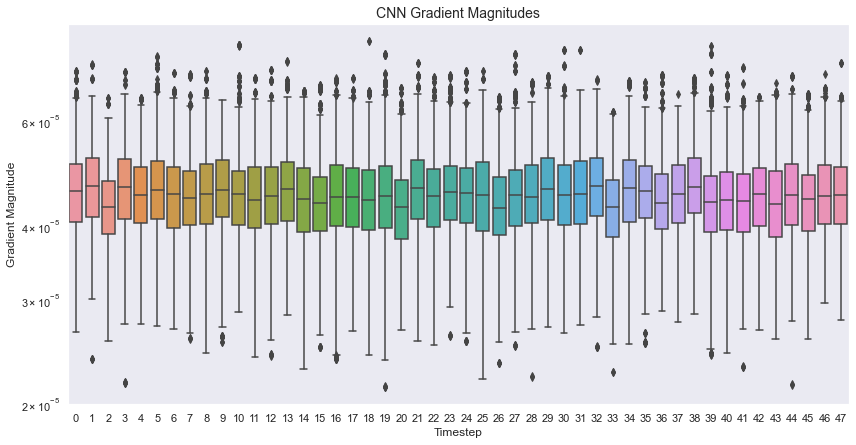

In [17]:
# Set default plotting style.
sns.set()

# Prepare collected gradients for plotting.
gradients_prepared = pd.melt(gradient_data, value_vars=gradient_data.columns)
gradients_prepared.columns = (r'Timestep', r'Gradient Magnitude')

# Define plotting figure and corresponding attributes.
fig, ax = plt.subplots(figsize=(14, 7))
ax.set_title(r'CNN Gradient Magnitudes', fontsize=14)
ax.set(yscale=r'log')

# Plot pre-processed gradients.
_ = sns.boxplot(x=r'Timestep', y=r'Gradient Magnitude', data=gradients_prepared, ax=ax)

In [18]:
# Set random seed for reproducibility.
np.random.seed(seed=42)
torch.manual_seed(seed=42)
kernel=3

# Create CNN instance for gradient recording.
target_device = torch.device(r'cuda' if torch.cuda.is_available() else r'cpu')
input_size = data_latch.num_characters
output_size = data_latch.num_targets
cnn_model = CNN(input_size=48,output_size=25,kernel=kernel).to(target_device)

In [19]:
gradient_data = collect_gradients(model=cnn_model, loader=data_loader_train)

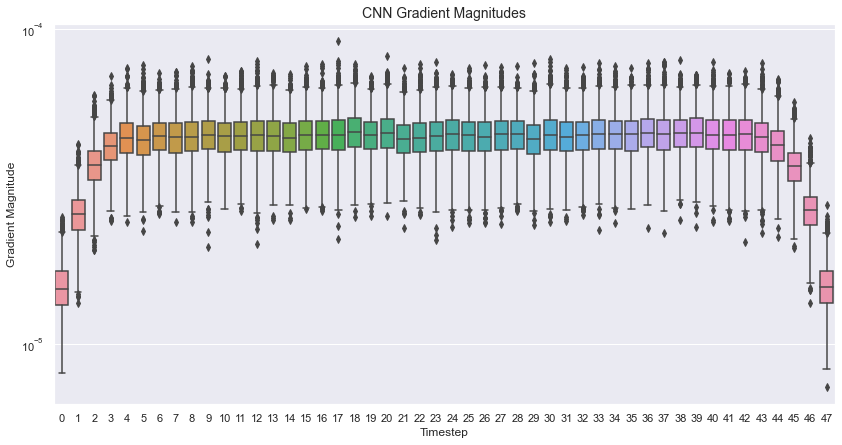

In [20]:
# Set default plotting style.
sns.set()

# Prepare collected gradients for plotting.
gradients_prepared = pd.melt(gradient_data, value_vars=gradient_data.columns)
gradients_prepared.columns = (r'Timestep', r'Gradient Magnitude')

# Define plotting figure and corresponding attributes.
fig, ax = plt.subplots(figsize=(14, 7))
ax.set_title(r'CNN Gradient Magnitudes', fontsize=14)
ax.set(yscale=r'log')

# Plot pre-processed gradients.
_ = sns.boxplot(x=r'Timestep', y=r'Gradient Magnitude', data=gradients_prepared, ax=ax)

In both cases the collected gradients are pretty much the same. The gradient magnitude does not increase nor decrease over time. For the kernel=3 the gradient magnitude is higher at the beginning and at the end. Overall, gradients are lower for kernel=1.

<a name="exercise-latch-lstm"></a><h2>Tackling Sequence Data with LSTMs</h2>
<p>During the accompanying exercise class, the <i>Long Short-Term Memory (LSTM)</i> was presented as a quite prominent and often used architecture in the recurrent case. It was designed and published by <a href="https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.676.4320&rep=rep1&type=pdf">Hochreiter and Schmidhuber</a>:
    <center>
        <cite>
            Hochreiter, S. and Schmidhuber, J., 1997. Long short-term memory. Neural computation, 9(8), pp.1735-1780.
        </cite>
    </center></p>

<p>It has to be noted, that the most crucial part of the LSTM, the <i>constant error carousel (CEC)</i>, was already discussed during <a href="https://people.idsia.ch//~juergen/SeppHochreiter1991ThesisAdvisorSchmidhuber.pdf">Hochreiter's diploma thesis</a> (in German):
    <center>
            <cite>
                Hochreiter, S., 1991. Untersuchungen zu dynamischen neuronalen Netzen. Diploma, Technische Universität München, 91(1).
            </cite>
    </center></p>

<p>In contrast to most other recurrent architectures like the Elman RNN, the <i>LSTM</i> is a bit more complex, but equally more powerful:
    <center>
        \begin{equation}
            \begin{split}
                i_{t} &= \sigma{\left(W_{ii}x_{t} + b_{ii} + W_{hi}h_{t-1} + b_{hi}\right)} \\
                \color{red}{f_{t}} &\color{red}{= \sigma{\left(W_{if}x_{t} + b_{if} + W_{hf}h_{t-1} + b_{hf}\right)}} \\
                g_{t} &= \tanh{\left(W_{ig}x_{t} + b_{ig} + W_{hg}h_{t-1} + b_{hg}\right)} \\
                o_{t} &= \sigma{\left(W_{io}x_{t} + b_{io} + W_{ho}h_{t-1} + b_{ho}\right)} \\
                c_{t} &= \color{red}{f_{t}\odot{}}c_{t-1} + i_{t}\odot{}g_{t} \\
                h_{t} &= o_{t}\odot{}\tanh{\left(c_{t}\right)}
            \end{split}
        \end{equation}
    </center></p>

<p>We are using the implementation provided by PyTorch, more information may be found in the <a href="https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html?highlight=lstm#torch.nn.LSTM">official documentation</a>. It has to be noted, the the <i>original</i> formulation did <i>not</i> contain an additional <i>forget gate</i> $f_{t}$ (see equations above), as this completely destroys the <i>constant error carousel</i> – it was introduced by <a href="https://www.mitpressjournals.org/doi/pdfplus/10.1162/089976600300015015">Gers et al.</a>:
<center>
    <cite>Gers, F.A., Schmidhuber, J. and Cummins, F., 1999. Learning to forget: Continual prediction with LSTM.
    </cite>
</center></p>
<p>Nonetheless, for <i>some</i> tasks, the forget gate seems to provide a useful addition. Hence, in this exercise you'll be tasked with activating the <i>forget gate</i> and interpreting the results.</p>

<a name="exercise-latch-lstm-one"></a><div class="alert alert-warning">
    Execute the notebook until here and try to solve the following tasks:
    <ul>
        <li>Implement a class <tt>LSTM</tt> with the following architecture:</li>
    </ul>
    <table style="text-align:center;vertical-align:middle">
        <th>Position</th>
        <th>Element</th>
        <th>Comment</th>
        <tr>
            <td>0</td>
            <td>input</td>
            <td>-</td>
        </tr>
        <tr>
            <td>1</td>
            <td>LSTM</td>
            <td>$256$ memory cells and a configurable initial forget gate bias (specified as an argument to <tt>\_\_init\_\_</tt>)</td>
        </tr>
        <tr>
            <td>2</td>
            <td>fully connected</td>
            <td><tt>num_targets</tt> output features (as specified during the data set creation)</td>
        </tr>
        <tr>
            <td>3</td>
            <td>output</td>
            <td>-</td>
        </tr>
    </table>
    <ul>
        <li>Train an <tt>LSTM</tt> network for $15$ epochs, print the training accuracy as well as the loss per epoch and report the final test set loss and accuracy. Use an initial forget gate bias of $0.0$. Do you expect the resulting performance?</li>
    </ul>
</div>

In [21]:
class LSTM(torch.nn.Module):
    """
    LSTM tailored to process latch sequence data.
    """
    
    def __init__(self, gate_bias, input_size: int, hidden_size: int = 256, output_size: int = 25):
        super(LSTM, self).__init__()
        self.lstm1 = torch.nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc1 = torch.nn.Linear(self.lstm1.hidden_size, output_size)
        
        # Deactivate forget gate to be in line with the original definition.
        for name, parameter in self.lstm1.named_parameters():
            if r'bias' in name:
                parameter.data[(parameter.shape[0] // 4):(parameter.shape[0] // 2)].fill_(gate_bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.lstm1(x)[0][:, -1, :]
        return self.fc1(x)

In [22]:
# Set random seed for reproducibility.
np.random.seed(seed=42)
torch.manual_seed(seed=42)

# Create LSTM instance and the corresponding optimizer to use.
target_device = torch.device(r'cuda' if torch.cuda.is_available() else r'cpu')
input_size = data_latch.num_characters
output_size = data_latch.num_targets
lstm_model = LSTM(input_size=input_size, output_size=output_size, gate_bias=0.0).to(target_device)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-2)

# Print the architecture of the LSTM instance.
print(lstm_model, end='\n\n')

# Train and evaluate LSTM instance on the latch sequence training set.
num_epochs = 15
for epoch in range(num_epochs):
    
    # Train LSTM instance for one epoch.
    u4.train_network(
        model=lstm_model, data_loader=data_loader_train, device=target_device, optimizer=optimizer)
    
    # Evaluate current LSTM instance.
    performance = u4.test_network(
        model=lstm_model, data_loader=data_loader_train, device=target_device)
    
    # Print result of current epoch to standard out.
    print(f'Epoch: {str(epoch + 1).zfill(len(str(num_epochs)))} ' +
          f'/ Loss: {performance[0]:.4f} / Accuracy: {performance[1]:.4f}')

# Evaluate final model on test data set.
performance = u4.test_network(
    model=lstm_model, data_loader=data_loader_test, device=target_device)
print(f'\nFinal loss: {performance[0]:.4f} / Final accuracy: {performance[1]:.4f}')

LSTM(
  (lstm1): LSTM(26, 256, batch_first=True)
  (fc1): Linear(in_features=256, out_features=25, bias=True)
)

Epoch: 01 / Loss: 0.0671 / Accuracy: 0.0479
Epoch: 02 / Loss: 0.0662 / Accuracy: 0.0729
Epoch: 03 / Loss: 0.0662 / Accuracy: 0.0625
Epoch: 04 / Loss: 0.0638 / Accuracy: 0.1162
Epoch: 05 / Loss: 0.0624 / Accuracy: 0.1165
Epoch: 06 / Loss: 0.0529 / Accuracy: 0.2122
Epoch: 07 / Loss: 0.0001 / Accuracy: 1.0000
Epoch: 08 / Loss: 0.0000 / Accuracy: 1.0000
Epoch: 09 / Loss: 0.0000 / Accuracy: 1.0000
Epoch: 10 / Loss: 0.0000 / Accuracy: 1.0000
Epoch: 11 / Loss: 0.0000 / Accuracy: 1.0000
Epoch: 12 / Loss: 0.0000 / Accuracy: 1.0000
Epoch: 13 / Loss: 0.0000 / Accuracy: 1.0000
Epoch: 14 / Loss: 0.0000 / Accuracy: 1.0000
Epoch: 15 / Loss: 0.0000 / Accuracy: 1.0000

Final loss: 0.0002 / Final accuracy: 0.9980


The result is expected, as LSTM seems to be overall better for solvig sequential tasks than CNN, as it is not guessing. Alsothe accuracy was pretty high in the lecture notebook for LSTM.

<a name="exercise-latch-lstm-two"></a><div class="alert alert-warning">
    Execute the notebook until here and try to solve the following tasks:
    <ul>
        <li>Create a <i>fresh</i> instance of <tt>LSTM</tt> and collect its gradients w.r.t. the network input using the latch sequence training set.</li>
        <li>Visualize the collected gradients accordingly. What do you observe? Comment on your results.</li>
    </ul>
</div>

In [23]:
# Set random seed for reproducibility.
np.random.seed(seed=42)
torch.manual_seed(seed=42)
kernel=3

# Create LSTM instance for gradient recording.
target_device = torch.device(r'cuda' if torch.cuda.is_available() else r'cpu')
input_size = data_latch.num_characters
output_size = data_latch.num_targets
lstm_model_fresh = LSTM(input_size=input_size, output_size=output_size, gate_bias=0.0).to(target_device)

In [24]:
gradient_data = collect_gradients(model=lstm_model_fresh, loader=data_loader_train)

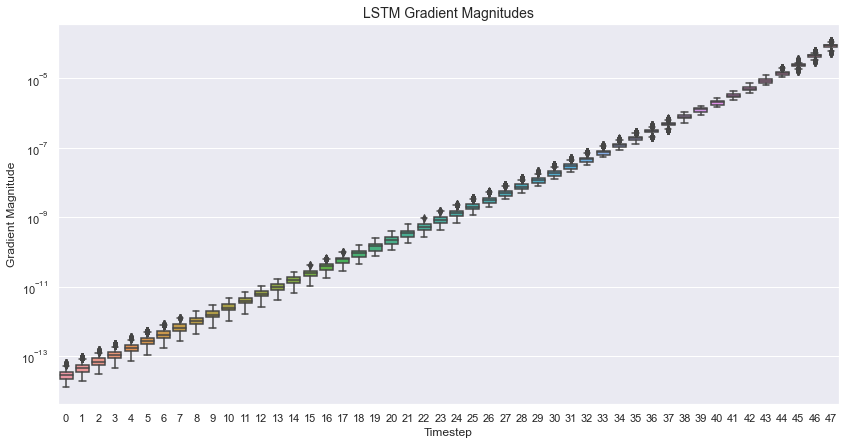

In [25]:
# Set default plotting style.
sns.set()

# Prepare collected gradients for plotting.
gradients_prepared = pd.melt(gradient_data, value_vars=gradient_data.columns)
gradients_prepared.columns = (r'Timestep', r'Gradient Magnitude')

# Define plotting figure and corresponding attributes.
fig, ax = plt.subplots(figsize=(14, 7))
ax.set_title(r'LSTM Gradient Magnitudes', fontsize=14)
ax.set(yscale=r'log')

# Plot pre-processed gradients.
_ = sns.boxplot(x=r'Timestep', y=r'Gradient Magnitude', data=gradients_prepared, ax=ax)

This figure prominently shows an exponential decrease over time in the gradient magnitude. The magnitude of the gradients of the loss with respect to the sequence elements becomes much smaller for elements in earlier positions than for elements in later positions. Trainning the models for more epochs would not help us.

<a name="exercise-latch-lstm-three"></a><div class="alert alert-warning">
    Execute the notebook until here and try to solve the following tasks:
    <ul>
        <li>Use the already trained <tt>LSTM</tt> instance from the beginning of this section for collecting its gradients w.r.t. the network input using the latch sequence training set.</li>
        <li>Visualize the collected gradients together with the gradients of the <i>freshly</i> created <tt>LSTM</tt> instance accordingly. What do you observe? Comment on your results.</li>
    </ul>
</div>

In [26]:
gradient_data = collect_gradients(model=lstm_model, loader=data_loader_train)

In [27]:
models = [lstm_model_fresh, lstm_model]
gradients = [collect_gradients(model=model, loader=data_loader_train) for model in models]

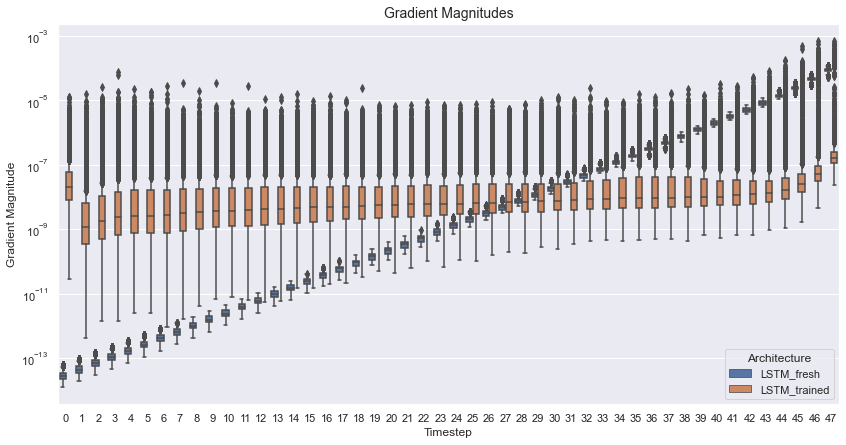

In [28]:
# Set default plotting style.
sns.set()

# Prepare collected gradients for plotting.
gradients_prepared = []
for model, gradient in zip(models, gradients):
    gradients_prepared.append(pd.melt(gradient, value_vars=gradient.columns))
    gradients_prepared[-1].columns = (r'Timestep', r'Gradient Magnitude')
    gradients_prepared[-1][r'Architecture'] = type(model).__name__
    gradients_prepared[0]['Architecture'] = "LSTM_fresh"
    gradients_prepared[-1]['Architecture'] = "LSTM_trained"

# Combine all gradients in a single data frame.
gradients_prepared = pd.concat(gradients_prepared)

# Define plotting figure and corresponding attributes.
fig, ax = plt.subplots(figsize=(14, 7))
ax.set_title(r'Gradient Magnitudes', fontsize=14)
ax.set(yscale=r'log')

# Plot pre-processed gradients.
_ = sns.boxplot(x=r'Timestep', y=r'Gradient Magnitude', hue=r'Architecture', data=gradients_prepared, ax=ax)

For the trained model the gradient magnitude is not exponentially decreasing. This is because there is no application function used, thus we do not have to deal with some multiplying problematics.

<a name="exercise-latch-lstm-one"></a><div class="alert alert-warning">
    Execute the notebook until here and try to solve the following tasks:
    <ul>
        <li>Train an <tt>LSTM</tt> network for $15$ epochs, print the training accuracy as well as the loss per epoch and report the final test set loss and accuracy. Use an initial forget gate bias of $1.0$. Do you expect the resulting performance?</li>
        <li>Use the newly trained <tt>LSTM</tt> instance for collecting its gradients w.r.t. the network input using the latch sequence training set.</li>
        <li>Visualize the collected gradients together with the gradients of the <i>freshly</i> created <tt>LSTM</tt> instance accordingly. What do you observe? Comment on your results.</li>
    </ul>
</div>

In [29]:
# Set random seed for reproducibility.
np.random.seed(seed=42)
torch.manual_seed(seed=42)

# Create LSTM instance and the corresponding optimizer to use.
target_device = torch.device(r'cuda' if torch.cuda.is_available() else r'cpu')
input_size = data_latch.num_characters
output_size = data_latch.num_targets
lstm_model = LSTM(input_size=input_size, output_size=output_size, gate_bias=1.0).to(target_device)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-2)

# Print the architecture of the LSTM instance.
print(lstm_model, end='\n\n')

# Train and evaluate LSTM instance on the latch sequence training set.
num_epochs = 15
for epoch in range(num_epochs):
    
    # Train LSTM instance for one epoch.
    u4.train_network(
        model=lstm_model, data_loader=data_loader_train, device=target_device, optimizer=optimizer)
    
    # Evaluate current LSTM instance.
    performance = u4.test_network(
        model=lstm_model, data_loader=data_loader_train, device=target_device)
    
    # Print result of current epoch to standard out.
    print(f'Epoch: {str(epoch + 1).zfill(len(str(num_epochs)))} ' +
          f'/ Loss: {performance[0]:.4f} / Accuracy: {performance[1]:.4f}')

# Evaluate final model on test data set.
performance = u4.test_network(
    model=lstm_model, data_loader=data_loader_test, device=target_device)
print(f'\nFinal loss: {performance[0]:.4f} / Final accuracy: {performance[1]:.4f}')

LSTM(
  (lstm1): LSTM(26, 256, batch_first=True)
  (fc1): Linear(in_features=256, out_features=25, bias=True)
)

Epoch: 01 / Loss: 0.0674 / Accuracy: 0.0417
Epoch: 02 / Loss: 0.0671 / Accuracy: 0.0446
Epoch: 03 / Loss: 0.0668 / Accuracy: 0.0495
Epoch: 04 / Loss: 0.0659 / Accuracy: 0.0778
Epoch: 05 / Loss: 0.0591 / Accuracy: 0.1787
Epoch: 06 / Loss: 0.0004 / Accuracy: 0.9993
Epoch: 07 / Loss: 0.0001 / Accuracy: 1.0000
Epoch: 08 / Loss: 0.0000 / Accuracy: 1.0000
Epoch: 09 / Loss: 0.0000 / Accuracy: 1.0000
Epoch: 10 / Loss: 0.0000 / Accuracy: 1.0000
Epoch: 11 / Loss: 0.0000 / Accuracy: 1.0000
Epoch: 12 / Loss: 0.0000 / Accuracy: 1.0000
Epoch: 13 / Loss: 0.0000 / Accuracy: 1.0000
Epoch: 14 / Loss: 0.0000 / Accuracy: 1.0000
Epoch: 15 / Loss: 0.0000 / Accuracy: 1.0000

Final loss: 0.0000 / Final accuracy: 1.0000


In [30]:
models = [lstm_model_fresh, lstm_model]
gradients = [collect_gradients(model=model, loader=data_loader_train) for model in models]

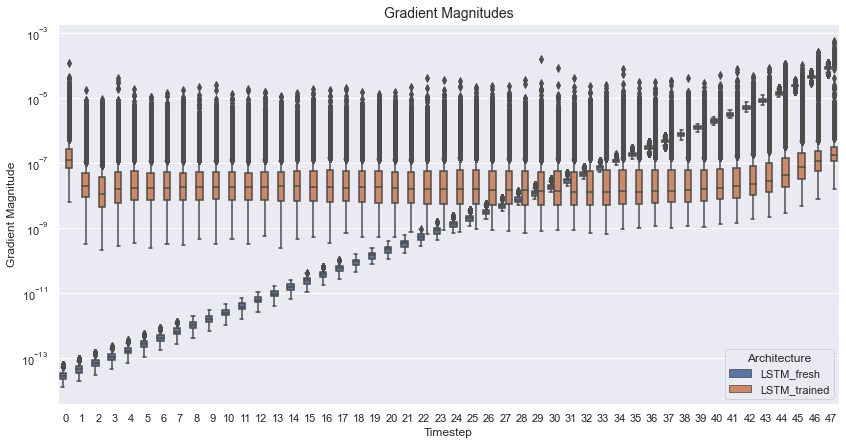

In [31]:
# Set default plotting style.
sns.set()

# Prepare collected gradients for plotting.
gradients_prepared = []
for model, gradient in zip(models, gradients):
    gradients_prepared.append(pd.melt(gradient, value_vars=gradient.columns))
    gradients_prepared[-1].columns = (r'Timestep', r'Gradient Magnitude')
    gradients_prepared[-1][r'Architecture'] = type(model).__name__
    gradients_prepared[0]['Architecture'] = "LSTM_fresh"
    gradients_prepared[-1]['Architecture'] = "LSTM_trained"

# Combine all gradients in a single data frame.
gradients_prepared = pd.concat(gradients_prepared)

# Define plotting figure and corresponding attributes.
fig, ax = plt.subplots(figsize=(14, 7))
ax.set_title(r'Gradient Magnitudes', fontsize=14)
ax.set(yscale=r'log')

# Plot pre-processed gradients.
_ = sns.boxplot(x=r'Timestep', y=r'Gradient Magnitude', hue=r'Architecture', data=gradients_prepared, ax=ax)

Magnitude of gradients is not exponentially decreasing for trained LSTM. For the same reason, as before. The gradients are bigger than before on average. Also, the overall accuracy of the model is higher for the open gate.